In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score



from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn import preprocessing
import pickle

import warnings
warnings.filterwarnings('ignore')


In [2]:
kf = pd.read_csv('../datasets/test.csv')

In [ ]:
kf.columns

In [3]:
# check for null, display the columns that has null value detected 
kf.loc[:, kf.isnull().any()]

# 7 columns with null value detected. 

,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km
0,877.431572,NaN,2.0,4.0,NaN,1.0,1.0
1,534.037705,NaN,1.0,3.0,NaN,NaN,NaN
2,817.050453,NaN,2.0,3.0,1.0,3.0,11.0
3,1272.737194,NaN,NaN,3.0,NaN,1.0,2.0
4,1070.963675,NaN,NaN,5.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...
16732,1120.535819,NaN,NaN,2.0,1.0,2.0,8.0
16733,519.046576,NaN,2.0,5.0,NaN,NaN,NaN
16734,685.922630,NaN,2.0,3.0,NaN,NaN,NaN
16735,846.849200,NaN,1.0,3.0,NaN,1.0,7.0


# Cleaning as per cleaning notebook 

In [4]:
# fillna(0) for columns with blank data in rows['Mall_Nearest_Distance'] = df['Mall_Nearest_Distance'].fillna(0)
kf.fillna(0, inplace = True)


---
# Feature Engineering

New kf1 with all the selected features

In [5]:
kf1 = kf[[
    'town', 'flat_type', 'floor_area_sqft', 'hdb_age', 'mid_storey', 'max_floor_lvl',
    'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 
    'mrt_name','Tranc_YearMonth', 'bus_interchange', 'mrt_nearest_distance']]

In [6]:
#change year month to numeric
kf1['Tranc_YearMonth'] = pd.to_numeric(kf1['Tranc_YearMonth'].str.replace('-',''))

In [7]:
kf['commercial'] = kf['commercial'].map(lambda x: 1 if x == 'Y' else 0)
kf['market_hawker'] = kf['market_hawker'].map(lambda x: 1 if x == 'Y' else 0)

# add following as Features
kf1['Ammenities_same_block'] = kf['commercial'] + kf['market_hawker']
kf1['Ammenities_within_500m'] = kf['Mall_Within_500m'] + kf['Hawker_Within_500m']
kf1['Ammenities_within_1km'] = (kf['Mall_Within_1km'] -  kf['Mall_Within_500m']) + (kf['Hawker_Within_1km'] - kf['Hawker_Within_500m'])
kf1['Ammenities_within_2km'] = (kf['Mall_Within_2km'] - kf['Mall_Within_1km'] ) + ( kf['Hawker_Within_2km'] - kf['Hawker_Within_1km'] )
kf1['pri_sch_dist_vacancy'] = kf['pri_sch_nearest_distance'] * kf['vacancy']
kf1['sec_sch_dist_cutoff'] = kf['sec_sch_nearest_dist'] * ( 1 / kf['cutoff_point'])  # whether numerator stay 1 or 100, the scores remain the same


In [8]:
mrt_colour_dict = {'Kallang': 'green', 'Bishan':['orange','red'], 'Bukit Batok': 'red', 'Khatib': 'red', 'MacPherson': ['orange', 'blue'], 
       'Kovan': 'purple', 'Bedok North': 'blue', 'Marymount':'orange', 'Sengkang': 'purple', 'Buangkok':'purple', 'Tampines': ['green', 'blue'], 
       'Tiong Bahru':'green', 'Bukit Panjang':'blue', 'Marsiling':'red', 'Woodlands South':'brown', 'Admiralty':'red', 'Pioneer':'green', 'Braddell':'red', 
       'Lakeside': 'green', 'Choa Chu Kang': 'red', 'Sembawang': 'red', 'Toa Payoh':'red','Geylang Bahru': 'blue',
       'Yew Tee':'red', 'Ang Mo Kio':'red', 'Telok Blangah':'orange', 'Tampines East':'blue',
       'Potong Pasir':'purple', 'Tampines West':'blue', 'Eunos':'green', 'Yio Chu Kang':'red',
       'Farrer Park':'purple', 'Bukit Gombak':'red', 'Clementi':'green', 'Yishun':'red', 'Punggol':'purple',
       'Jurong East': ['green','red'], 'Tanah Merah':'green', 'Chinese Garden':'green', 'Kembangan':'green',
       'Pasir Ris':'green', 'Jalan Besar':'blue', 'Hougang':'purple', 'Buona Vista':['green','orange'], 'Kaki Bukit':'blue',
       'Cashew':'blue', 'Bedok':'green', 'Boon Keng':'purple', 'Woodlands':'brown', 'Simei':'green', 'Boon Lay':'green',
       'Dakota':'orange', 'Redhill':'green', 'Canberra':'blue', 'Beauty World':'blue', 'Commonwealth':'green',
       'Lorong Chuan':'orange', 'Tai Seng':'orange', 'Bedok Reservoir':'blue', 'Holland Village':'orange',
       'Ubi':'blue', 'HarbourFront':['orange','purple'], 'Dover':'green', 'Chinatown':['blue','purple'], 'Queenstown':'green',
       'Mattar':'blue', 'one-north':'orange', 'Mountbatten':'orange', 'Serangoon':['orange','purple'], 'Farrer Road':'orange',
       'Lavender':'green', 'Outram Park':['green', 'purple'], 'Caldecott':['orange','brown'], 'Aljunied':'green', 'Little India':['blue', 'purple'],
       'Upper Changi':'blue', 'Bartley':'orange', 'Woodlands North':'brown', 'Paya Lebar':['green', 'orange'],
       'Tanjong Pagar':'green', 'Woodleigh':'purple', 'Hillview':'blue', 'Bencoolen':'blue',
       'Labrador Park':'orange', 'Rochor':'blue', 'Nicoll Highway':'orange', 'Clarke Quay':'purple',
       'Tan Kah Kee':'blue', 'Bras Basah':'orange', 'Changi Airport':['green','blue'], 'Bugis':['green','blue'],
       'Bendemeer':'blue', 'Botanic Gardens':['orange', 'blue'], 'Novena':['blue','red'] } 
kf1['mrt_colour'] = kf['mrt_name'].map(mrt_colour_dict)

In [9]:
region = {'BUKIT BATOK':'west', 'BUKIT PANJANG':'west', 'JURONG WEST':'west', 'CHOA CHU KANG':'west', 'CLEMENTI':'west', 'JURONG EAST':'west', 
          'SEMBAWANG':'north', 'WOODLANDS':'north', 'YISHUN':'north', 
          'HOUGANG':'north_east', 'SENGKANG':'north_east', 'SERANGOON':'north_east', 'PUNGGOL':'north_east', 'ANG MO KIO':'north_east', 
          'BEDOK':'east', 'TAMPINES':'east', 'PASIR RIS':'east', 
          'KALLANG/WHAMPOA':'central', 'BISHAN':'central', 'GEYLANG':'central', 'BUKIT MERAH':'central', 'TOA PAYOH':'central', 'CENTRAL AREA':'central', 'QUEENSTOWN':'central', 'BUKIT TIMAH':'central', 'MARINE PARADE':'central'}
kf1['region'] = kf1['town'].map(region)

In [10]:
kf1.mrt_colour.value_counts()

mrt_colour
red                 4837
green               4015
purple              3395
blue                2323
brown                415
orange               410
[green, blue]        372
[orange, purple]     277
[orange, red]        204
[green, red]         183
[green, orange]      124
[orange, blue]        69
[green, purple]       63
[blue, purple]        29
[orange, brown]       19
[blue, red]            2
Name: count, dtype: int64

In [11]:
kf2 = pd.get_dummies(kf1, columns =['town'],dtype=int)


In [12]:
kf2 = pd.get_dummies(kf2, columns =['flat_type'],dtype=int)

In [13]:
kf2['mrt_no'] = kf2.mrt_colour.apply(lambda x: len(x) if isinstance(x,list) else 1) 


In [14]:
kf2 = pd.get_dummies(kf2,columns = ['region'], dtype = int)

In [15]:
kf2.drop(columns =['mrt_name'], inplace = True)

In [16]:
kf2.drop(columns =['mrt_colour'], inplace = True)

In [17]:
kf2.to_csv('../datasets/kf2check.csv', index = False)

In [18]:
kf2.loc[:, kf2.isnull().any()]


""
0
1
2
3
4
...
16732
16733
16734
16735


In [19]:
# import pickled linear regression model 
with open('linear_regression_model.pkl', 'rb') as f:
    lr = pickle.load(f)

In [20]:
# import standardscaler 
with open('standardscaler.pkl','rb') as g:
    ss = pickle.load(g)

In [21]:
k_train_sc = ss.transform(kf2)

In [22]:
kaggle_predictions = lr.predict(k_train_sc)

In [23]:
print(kaggle_predictions)

[354533.87344598 499056.27031119 360595.87344598 ... 395712.27031119
 484249.87344598 356928.27031119]


In [24]:
kpdf = pd.DataFrame(kaggle_predictions, columns = ['Predicted'])

In [25]:
test = pd.read_csv('../datasets/test.csv')

In [26]:
new_column_name = 'id'
kpdf.insert(0, new_column_name, test['id'])

In [27]:
kpdf.to_csv('../datasets/kaggle_group2_submit.csv', index = False)

In [28]:
from IPython.display import Image

In [39]:
image_path = "kaggle_ss.png"

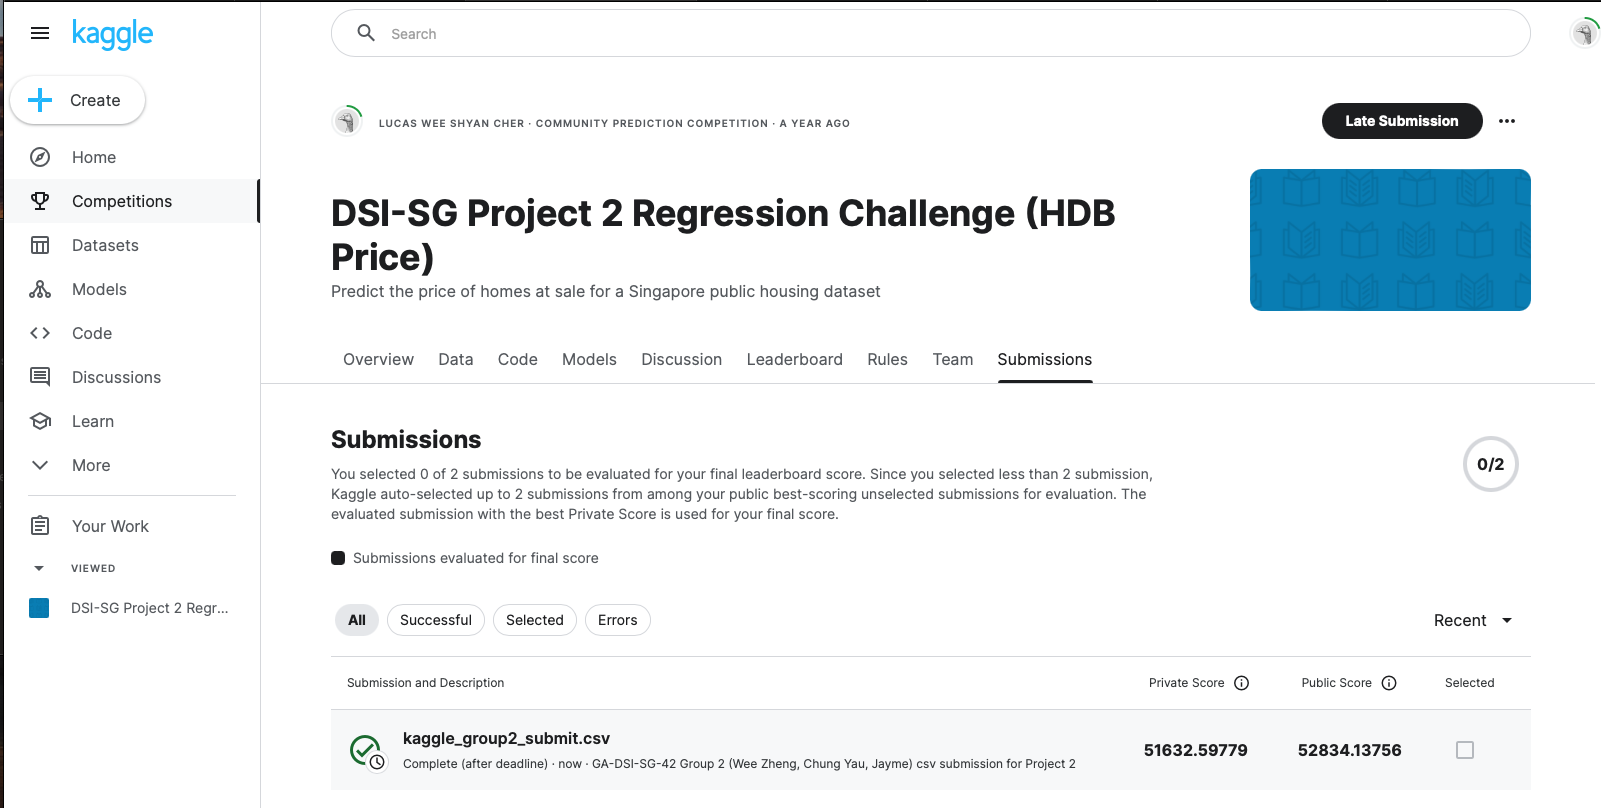

In [40]:
Image(image_path)